# Entorno

In [17]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
from random import randint
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.extract import load_heart_noised_paths
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from scripts.plot import plot_audio_sample, plot_prediction_from_tuple
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

# Relación de datos

In [18]:
heart_noised = load_heart_noised_paths(
    clean_dir="data/heart_sound_test_small",
    noised_dir="data/heart_noised_test_small",
)

heart_noised[:3]

[('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_154noise_-17dB_louder.wav'),
 ('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_1noise_-14dB_louder.wav'),
 ('data/heart_sound_test_small/val/healthy/e00052.wav',
  'data/heart_noised_test_small/-val-healthy-e00052_seg_538noise_-15dB_louder.wav')]

# Cómo suena?

In [19]:
test = heart_noised[randint(0, len(heart_noised))]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [20]:
audio_clean

In [21]:
audio_noisy

# Cómo se ve?

In [22]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())
clean_array.shape, noisy_array.shape

((40125,), (40124,))

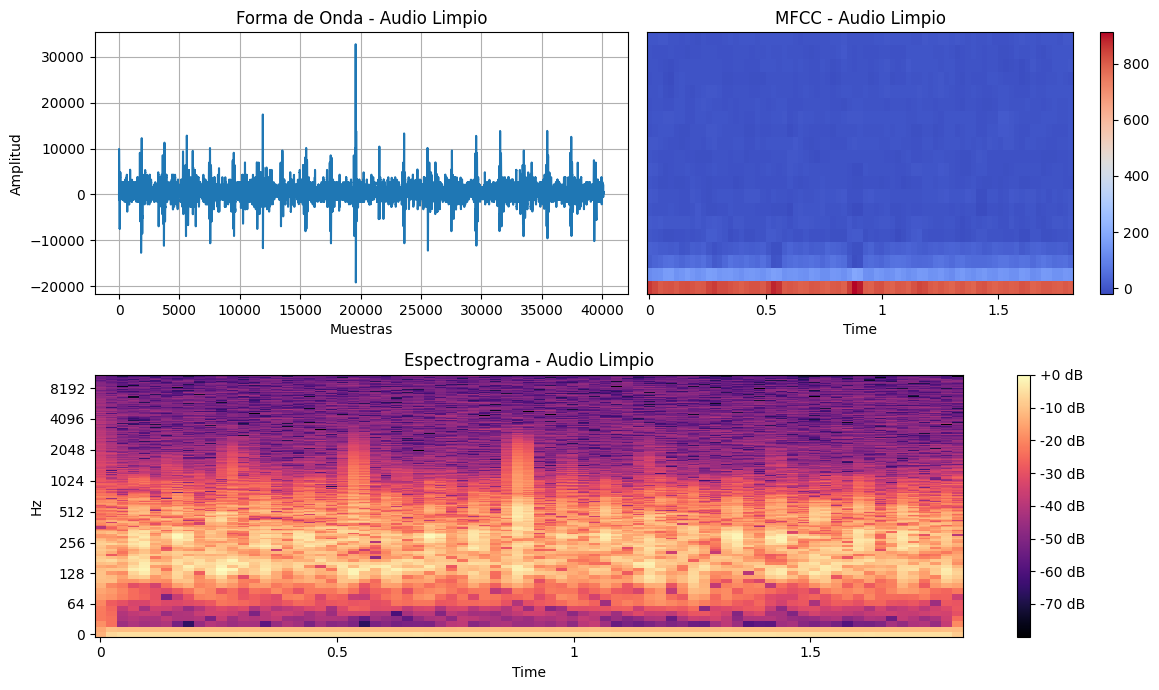

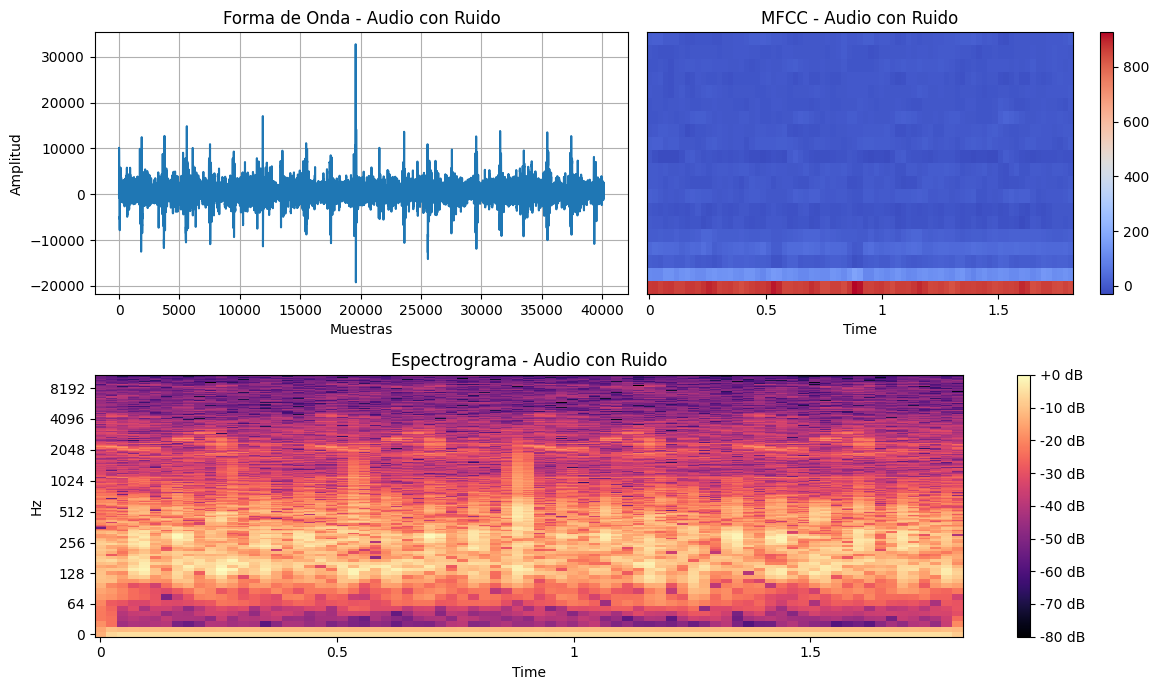

In [23]:
plot_audio_sample(clean_array, "Audio Limpio")
plot_audio_sample(noisy_array, "Audio con Ruido")

# Arquitectura

In [24]:
class Autoencoder(pl.LightningModule):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128), nn.ReLU(), nn.Linear(128, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

    def training_step(self, batch, batch_idx):
        clean, noisy = batch
        # Forward pass
        decoded = self(noisy)
        # Calculamos la pérdida (error de reconstrucción)
        train_loss = nn.MSELoss()(decoded, clean)
        # Registramos la pérdida para su monitoreo
        self.log("train_loss", train_loss, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        clean, noisy = batch
        decoded = self(noisy)
        val_loss = nn.MSELoss()(decoded, clean)
        self.log("val_loss", val_loss, on_epoch=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

        scheduler = {
            "scheduler": CyclicLR(
                optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False
            ),
            "interval": "step",  # Frecuencia de ajuste del LR scheduler (en cada paso)
        }

        # scheduler = {
        #     'scheduler': ReduceLROnPlateau(optimizer, patience=3),
        #     'monitor': 'val_loss',  # Métrica para monitorear
        #     'interval': 'epoch',    # Frecuencia de ajuste del LR scheduler
        #     'frequency': 1          # Igual a interval, ya que estamos usando 'epoch'
        # }

        return [optimizer], [scheduler]

# CustomDataset class

In [25]:
class CoraCleanerDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data_tuples = data_tuples
        self.transform = transform
        # Calcular la duración mínima de todos los audios
        self.min_duration = self.calculate_min_duration()

    def __len__(self):
        return len(self.data_tuples)

    def calculate_min_duration(self):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        return min(self.durations)

    def adjust_audio_duration(self, audio, target_duration):
        if audio.shape[-1] > target_duration:
            audio = audio[..., :target_duration]
        return audio

    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized.reshape(1, 1, -1)

    def __getitem__(self, idx):
        clean_audio_path = self.data_tuples[idx][0]
        clean_audio, sample_rate = torchaudio.load(clean_audio_path)
        clean_audio = self.adjust_audio_duration(clean_audio, self.min_duration)
        clean_audio = self.normalize_audio(clean_audio)

        noisy_audio_path = self.data_tuples[idx][1]
        noisy_audio, sample_rate = torchaudio.load(noisy_audio_path)
        noisy_audio = self.adjust_audio_duration(noisy_audio, self.min_duration)
        noisy_audio = self.normalize_audio(noisy_audio)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio, noisy_audio

In [26]:
from scripts.transform import spec_n_mfcc

cleaner_dataset = CoraCleanerDataset(heart_noised, spec_n_mfcc)
# cleaner_dataset = CoraCleanerDataset(heart_noised)

print(len(cleaner_dataset))
cleaner_dataset[5][0].shape, cleaner_dataset[5][1].shape

80


(torch.Size([1, 1, 34615]), torch.Size([1, 1, 34615]))

In [27]:
# import matplotlib.pyplot as plt

# plt.plot(cleaner_dataset[0][0].reshape(-1)[:cleaner_dataset.min_duration])
# plt.plot(cleaner_dataset[0][-1].reshape(-1)[:cleaner_dataset.min_duration])

# Entrenamiento, validación y prueba

In [28]:
batch_size = 16
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(cleaner_dataset))
val_size = int(val_ratio * len(cleaner_dataset))
test_size = len(cleaner_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    cleaner_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Callbacks

In [29]:
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# callbacks = [checkpoint, early_stopping, lr_monitor]
callbacks = [checkpoint, lr_monitor]

# Entrenamiento

In [30]:
input_size = cleaner_dataset[0][0].shape[-1]
model = Autoencoder(input_size=input_size, latent_dim=64)

logger = TensorBoardLogger("logs/", name="cora_cleaner")

trainer = pl.Trainer(max_epochs=3, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 4.4 M 
1 | decoder | Sequential | 4.5 M 
---------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.651    Total estimated model params size (MB)
/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck

Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s, v_num=1]


# Predicción

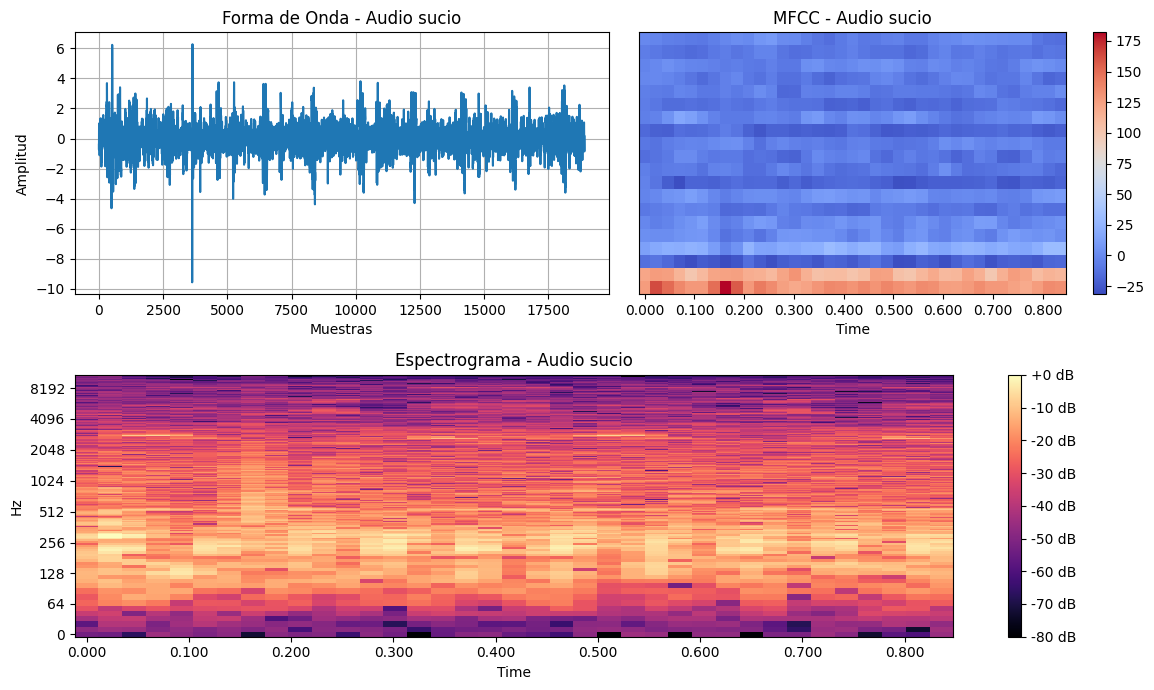

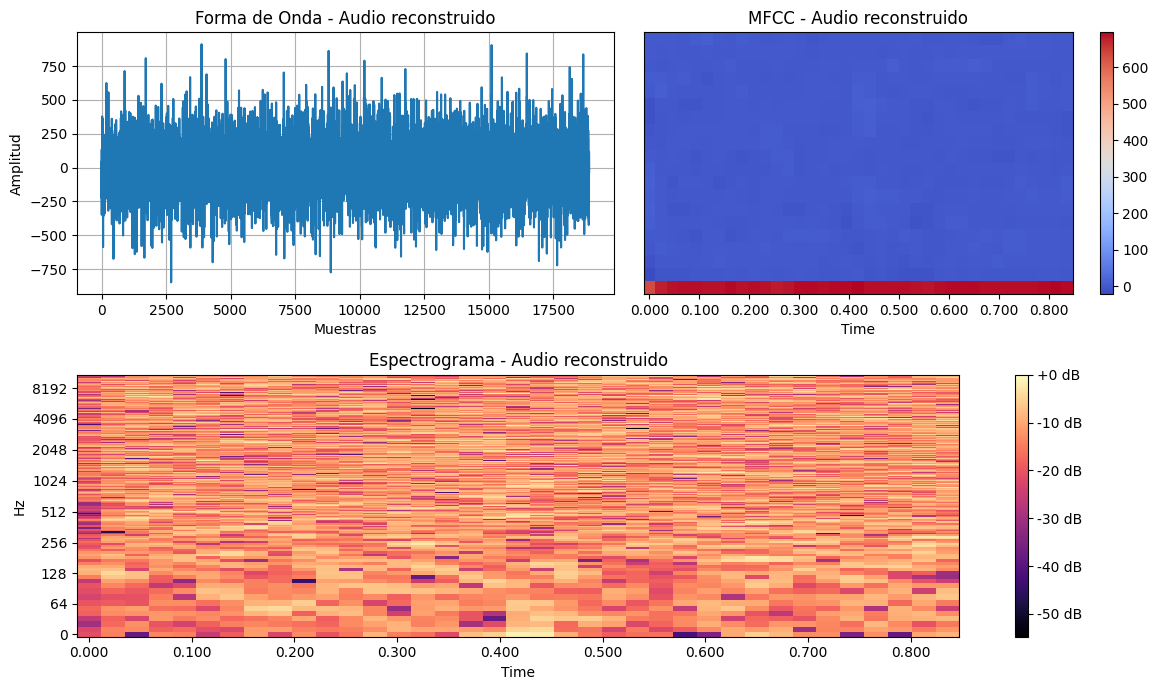

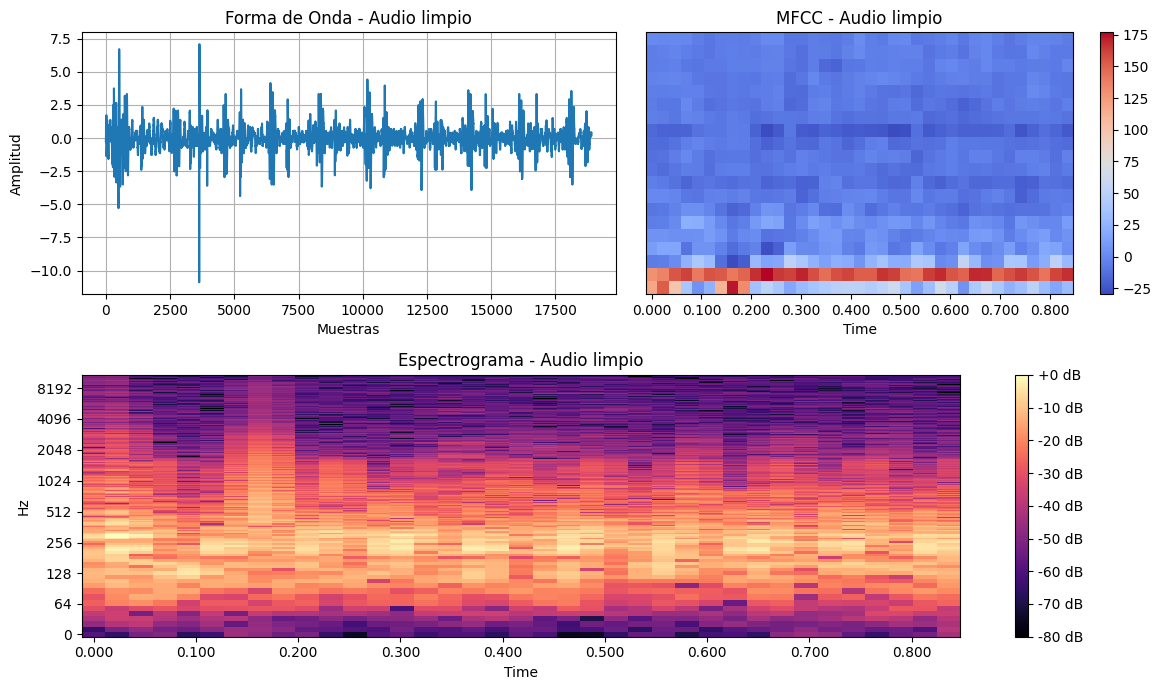

In [31]:
to_pred = cleaner_dataset[randint(0, len(cleaner_dataset))]

plot_prediction_from_tuple(
    model=model,
    clean_noisy_tuple=to_pred,
    duration=cleaner_dataset.min_duration,
)

In [32]:
# Descomentar para revisar el Tensorboard en web
# !tensorboard --logdir=path_to_logs_directory

# O en VisualStudioCode, Ctrl+Shift+P -> Launch Tensorboard